If you are using VSCode, simply clone the repository in a container volume. Otherwise, you'll need standard Anaconda packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Helper functions for later

In [2]:
def get_dispatch(market, intercept, slope):
    return np.maximum(
        np.minimum(
            intercept + slope*market.Bid - market.Capacity.cumsum().shift(fill_value=0),
            market.Capacity
        ),
        0
    )

def visualize(market, intercept, slope, ax):
    ax.step(market.Capacity.cumsum(), market.Bid)
    ax.plot([intercept + slope*market.Bid.max(), intercept], [market.Bid.max(), 0])
    dispatched = market.loc[market.Dispatch > 0].iloc[-1]
    ax.hlines(
        dispatched['Total Marginal Cost'] + dispatched.Surplus/dispatched.Dispatch,
        ax.get_xlim()[0], ax.get_xlim()[1],
        color='black',
        linestyle='dashed'
    )
    ax.grid()

Load and process portfolio data

In [3]:
portfolios = pd.read_excel('ESG Portfolios.xlsx')
portfolios.columns = portfolios.iloc[0:3].bfill().iloc[0]
portfolios = portfolios.iloc[3:]
portfolios = portfolios[portfolios['UNIT NAME'] != 'Totals']
portfolios.dropna(axis='index', how='all', inplace=True)
portfolios.dropna(axis='columns', how='all', inplace=True)
portfolios['portfolio'] = (portfolios.isna().any(axis='columns') * portfolios['UNIT NAME']).replace('', np.NaN).ffill()
portfolios.dropna(axis='index', how='any', inplace=True)
portfolios.set_index(['Location', 'portfolio', 'UNIT NAME'], inplace=True)
portfolios.sort_index(axis='index',level=['Location', 'portfolio'], inplace=True)

Load and process profile data

In [4]:
profiles = pd.read_excel('ESG Demand Year 2.xlsx', header=2, index_col=[1,0,2])
profiles.dropna(axis='index', how='any', inplace=True)
profiles.sort_index(inplace=True)

``simulate`` accepts an hour and a bid, both of which are pandas ``Series`` objects with indices taken from the ``portfolios`` and ``profiles`` objects, respectively. It returns a copy of ``portfolios`` with dispatch and surplus results.

In [5]:
def simulate_hour(hour, bid, pay_as_bid, transmission_capacity, co2_tax):

    results = portfolios.copy()
    results['Bid'] = bid
    results.sort_values('Bid', inplace=True)
    results['Dispatch'] = get_dispatch(results, hour.sum()['Load Intercept'], hour.sum()['Load Slope'])

    generation = results.Dispatch.groupby('Location').sum()
    consumption = np.linalg.inv(
        np.array(
            [
                np.array([1,-1])*np.array([1/hour.loc[location, 'Load Slope'] for location in hour.index]),
                [1, 1]
            ]
        )
    )@np.array(
        [
            np.array([1, -1])@(hour['Load Intercept']/hour['Load Slope']),
            results.Dispatch.sum()
        ]
    )
    shortage = consumption - generation

    if np.abs(shortage).mean() >= transmission_capacity:

        shortage = transmission_capacity*np.sign(shortage)
        results.Dispatch = results.groupby('Location', group_keys=False).apply(
            lambda market: get_dispatch(
                market, hour.loc[market.name, 'Load Intercept'] 
                - shortage[market.name], hour.loc[market.name, 'Load Slope']
            )
        )
        generation = results.Dispatch.groupby('Location').sum()
        consumption = generation + shortage

    price = (consumption - hour['Load Intercept'])/hour['Load Slope']

    results['Surplus'] = results.groupby('Location', group_keys=False).apply(
        lambda market: market.Dispatch*(
            (market.Bid if pay_as_bid else price[market.name]) - market['Total Marginal Cost']
        ) 
    )

    results['Profit'] = results.groupby('Location', group_keys=False).apply(
        lambda market: market.Surplus
        - market.Dispatch*(co2_tax*market.CO2) 
        - market['O&M/Day ($)']/4
    )
    return results

A wrapper function to simulate a full year given a bid profile

In [6]:
def simulate(bids):
    return profiles.groupby(['Day', 'Hour']).apply(
        lambda hour: simulate_hour(
            hour = hour.droplevel(['Day', 'Hour']), 
            bid = bids[hour.name],
            pay_as_bid = hour.name[0] == 1,
            transmission_capacity = 500 if hour.name[0] == 2 else 10000,
            co2_tax = 50*(hour.name[0] == 3)
        )
    )

As a baseline, bid marginal cost every hour.

In [7]:
bids = pd.DataFrame(
    {
        (day, hour): portfolios['Total Marginal Cost'] 
        + portfolios.CO2*50*(day == 3)
        for (day, hour) in profiles.index.droplevel('Location')
        }
)
bids.columns.rename(profiles.index.droplevel('Location').names, inplace=True)

results = simulate(bids)

For the first hour, each generator with marginal cost less than the clearing price bids the clearing price (minus one cent). The resulting profit values are the results in the competitive case, which are a lower bound on our expected profits.

In [8]:
prices = results.loc[1].groupby('Hour').apply(
    lambda market: market[market.Dispatch > 0].iloc[-1]
)
prices = prices['Total Marginal Cost'] + prices.Surplus/prices.Dispatch
bids[1] = bids[1].apply(lambda row: np.maximum(row, prices-.01), axis='columns')
results = simulate(bids)
results.Profit.groupby('portfolio').sum()

portfolio
Bay Views        514575.425072
Beachfront       492468.866314
Big Coal         480021.738713
Big Gas          417522.003522
East Bay         272841.506724
Fossil Light    1250141.764889
Old Timers      1044384.447807
Name: Profit, dtype: object

To run a scenario, modify ``bids`` and then run ``simulate(bids)``. ``bids`` has the following format, which must be kept the same - only modify the values!

In [9]:
bids

Day                                                 1                        \
Hour                                                1          2          3   
Location portfolio    UNIT NAME                                               
North    Bay Views    MORRO BAY 1&2         39.490000  41.934444  52.490000   
                      MORRO BAY 3&4         39.490000  41.934444  52.490000   
                      MOSS LANDING 6        39.490000  41.934444  52.490000   
                      MOSS LANDING 7        39.490000  41.934444  52.490000   
                      OAKLAND               61.166667  61.166667  61.166667   
         East Bay     CONTRA COSTA 4&5      58.277778  58.277778  58.277778   
                      CONTRA COSTA 6&7      39.500000  41.934444  52.490000   
                      PITTSBURGH 1-4        40.944444  41.934444  52.490000   
                      PITTSBURGH 5&6        39.490000  41.934444  52.490000   
                      PITTSBURGH 7          59.722222  59.722222  59.722222   
                      POTRERO HILL          69.833333  69.833333  69.833333   
         Fossil Light DIABLO CANYON 1       39.490000  41.934444  52.490000   
                      HELMS                 39.490000  41.934444  52.490000   
                      HUMBOLDT              47.444444  47.444444  52.490000   
                      HUNTERS POINT 1&2     49.166667  49.166667  52.490000   
                      HUNTERS POINT 4       75.888889  75.888889  75.888889   
South    Beachfront   COOLWATER             42.388889  42.388889  52.490000   
                      ELLWOOD               75.611111  75.611111  75.611111   
                      ETIWANDA 1-4          42.666667  42.666667  52.490000   
                      ETIWANDA 5            62.888889  62.888889  62.888889   
                      MANDALAY 1&2          39.490000  41.934444  52.490000   
                      MANDALAY 3            52.055556  52.055556  52.490000   
                      ORMOND BEACH 1        39.490000  41.934444  52.490000   
                      ORMOND BEACH 2        39.490000  41.934444  52.490000   
         Big Coal     ALAMITOS 7            73.722222  73.722222  73.722222   
                      FOUR CORNERS          39.490000  41.934444  52.490000   
                      HUNTINGTON BEACH 1&2  40.500000  41.934444  52.490000   
                      HUNTINGTON BEACH 5    66.500000  66.500000  66.500000   
                      REDONDO 5&6           41.944444  41.944444  52.490000   
                      REDONDO 7&8           41.944444  41.944444  52.490000   
         Big Gas      EL SEGUNDO 1&2        44.833333  44.833333  52.490000   
                      EL SEGUNDO 3&4        41.222222  41.934444  52.490000   
                      ENCINA                41.666667  41.934444  52.490000   
                      KEARNY                90.055556  90.055556  90.055556   
                      LONG BEACH            52.500000  52.500000  52.500000   
                      NORTH ISLAND          65.500000  65.500000  65.500000   
                      SOUTH BAY             43.833333  43.833333  52.490000   
         Old Timers   BIG CREEK             39.490000  41.934444  52.490000   
                      HIGHGROVE             49.611111  49.611111  52.490000   
                      MOHAVE 1              39.490000  41.934444  52.490000   
                      MOHAVE 2              39.490000  41.934444  52.490000   
                      SAN BERNADINO         53.944444  53.944444  53.944444   

Day                                                            2             \
Hour                                                4          1          2   
Location portfolio    UNIT NAME                                               
North    Bay Views    MORRO BAY 1&2         41.656667  38.777778  38.777778   
                      MORRO BAY 3&4         41.656667  36.611111  36.611111   
                      MOSS LANDING 6        41.65

Plot the north and south markets together. Do this for days 1, 3, and 4.

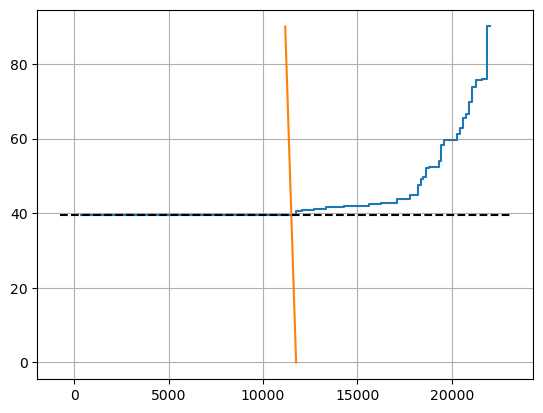

In [10]:
day = 1
hour = 1

fig, ax = plt.subplots()
hour_results = results.loc[day, hour]
(intercept, slope) = profiles.loc[(['North', 'South'], day, hour)].sum()
visualize(hour_results, intercept, slope, ax)
fig.show()

Plot the north and south markets seperately. Do this for day 2.

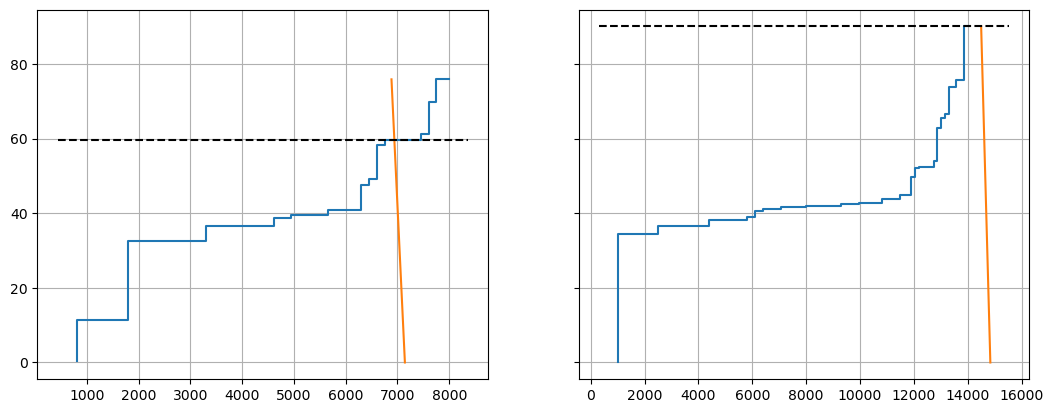

In [11]:
day = 2
hour = 3

fig, ax = plt.subplots(1,2,sharey=True)
fig.set_size_inches(fig.get_size_inches()*[2,1])
hour_results = results.loc[day, hour]
(intercept, slope) = profiles.loc[(['North', 'South'], day, hour)]
[
    visualize(
        market, 
        profiles.loc[(location, day, hour),'Load Intercept'], 
        profiles.loc[(location, day, hour),'Load Slope'],  
        ax[i]
    ) 
    for i, (location, market) in enumerate(hour_results.groupby('Location'))
]
fig.show()

To check the market details for a certain day and location, run ``results.loc[day,hour,location]``, where ``location`` is either ``'North'`` or ``'South'``. For days 1, 3, and 4, simply omit the location argument and view the whole market.

In [12]:
results.loc[(4,1)]

0                                              Fuel Capacity  Heat Rate  \
Location portfolio    UNIT NAME                                           
South    Old Timers   BIG CREEK               Hydro     1000          0   
North    Fossil Light HELMS                   Hydro      800          0   
                      DIABLO CANYON 1       Nuclear     1000          1   
         Bay Views    MOSS LANDING 6            Gas      750   6.901235   
                      MOSS LANDING 7            Gas      750   6.901235   
South    Old Timers   MOHAVE 1                 Coal      750         10   
                      MOHAVE 2                 Coal      750         10   
         Big Coal     FOUR CORNERS             Coal     1900  11.666667   
North    Bay Views    MORRO BAY 3&4             Gas      665   8.024691   
         East Bay     PITTSBURGH 5&6            Gas      650   8.024691   
South    Beachfront   ORMOND BEACH 2            Gas      700   8.345679   
                      ORMOND BEACH 1            Gas      700   8.345679   
North    Bay Views    MORRO BAY 1&2             Gas      335   8.506173   
South    Beachfront   MANDALAY 1&2              Gas      300   8.345679   
North    East Bay     CONTRA COSTA 6&7          Gas      700   8.666667   
South    Big Coal     HUNTINGTON BEACH 1&2      Gas      300   8.666667   
North    East Bay     PITTSBURGH 1-4            Gas      650   8.987654   
South    Big Gas      EL SEGUNDO 3&4            Gas      650    8.82716   
                      ENCINA                    Gas      950   9.148148   
         Big Coal     REDONDO 5&6               Gas      350   8.987654   
                      REDONDO 7&8               Gas      950   8.987654   
         Beachfront   COOLWATER                 Gas      650   9.308642   
                      ETIWANDA 1-4              Gas      850   9.148148   
         Big Gas      SOUTH BAY                 Gas      700    9.62963   
                      EL SEGUNDO 1&2            Gas      400    9.62963   
North    Fossil Light HUMBOLDT                  Gas      150  10.432099   
                      HUNTERS POINT 1&2         Gas      150  10.592593   
South    Old Timers   HIGHGROVE                 Gas      150   10.91358   
         Beachfront   MANDALAY 3                Gas      150  11.234568   
         Big Gas      LONG BEACH                Gas      550  11.555556   
         Old Timers   SAN BERNADINO             Gas      100  11.876543   
North    East Bay     CONTRA COSTA 4&5          Gas      150  12.839506   
                      PITTSBURGH 7              Gas      700  13.160494   
         Bay Views    OAKLAND                   Gas      150  13.481481   
South    Beachfront   ETIWANDA 5                Gas      150  13.641975   
         Big Gas      NORTH ISLAND              Gas      150  14.444444   
         Big Coal     HUNTINGTON BEACH 5        Gas      150  14.444444   
North    East Bay     POTRERO HILL              Gas      150  15.407407   
South    Big Coal     ALAMITOS 7                Gas      250  16.049383   
         Beachfront   ELLWOOD                   Gas      300  16.691358   
North    Fossil Light HUNTERS POINT 4           Gas      250  16.530864   
South    Big Gas      KEARNY                    Gas      200  19.901235   

0                                          Fuel Price  Fuel Cost O&M/MWh  \
Location portfolio    UNIT NAME                                            
South    Old Timers   BIG CREEK                     0          0       0   
North    Fossil Light HELMS                         0          0     0.5   
                      DIABLO CANYON 1             7.5        7.5       4   
         Bay Views    MOSS LANDING 6              4.5  31.055556     1.5   
                      MOSS LANDING 7              4.5  31.055556     1.5   
South    Old Timers   MOHAVE 1                      3         30     4.5   
                      MOHAVE 2                      3         30     4.5   
         Big Co

Finally, to check the single-hour surplus, run the following cell. Keep ``day`` and ``hour`` as variables - that is, only change their values, not the third line.

In [13]:
hour = 1
day = 1
results.loc[day, hour].groupby('portfolio').apply(
    lambda market: (market.Surplus - market.Dispatch*50*market.CO2*(day == 3)).sum()
)

portfolio
Bay Views       12554.722222
Beachfront       2138.555556
Big Coal         5681.000000
Big Gas             0.000000
East Bay         1871.277778
Fossil Light    59182.000000
Old Timers      46975.000000
dtype: float64